In [37]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as mplt


dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True) #get information about the dataset by setting with_info=True
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes #5

print(dataset_size)
print(class_names)
print(n_classes)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


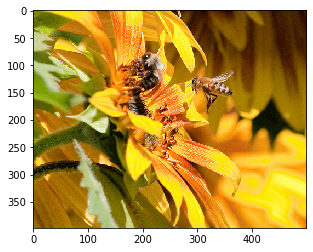

In [38]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75]) 
#let’s take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

print(test_set)
print(valid_set)
print(train_set)

image,label=next(iter(train_set))
mplt.imshow(image)

We also need to run the images through mobilenet_v2's preprocess_input() function and it's CNN expects 224 × 224 images, so we need pre-process and resize them.

In [39]:
def preprocess(image, label):
    new_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.mobilenet_v2.preprocess_input(new_image)
    return final_image, label

def augmented_preprocess_to_train(image, label):
    new_image=tf.image.flip_left_right(image)
    new_image=tf.image.adjust_brightness(new_image,0.4)
    new_image=tf.image.central_crop(new_image,central_fraction=0.5)
    new_image=tf.image.adjust_saturation(new_image,4)
    new_image = tf.image.resize(new_image, [224, 224])
    final_image = keras.applications.mobilenet_v2.preprocess_input(new_image)
    return final_image, label

def visualize(original_image,augmented_image):
    fig=mplt.figure()
    mplt.subplot(1,2,1)
    mplt.title('Original Image')
    mplt.imshow(original_image)
    
    mplt.subplot(1,2,2)
    mplt.title('Augmented Image')
    mplt.imshow(augmented_image)

batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(augmented_preprocess_to_train).batch(batch_size)
valid_set = valid_set.map(preprocess).batch(batch_size)
test_set = test_set.map(preprocess).batch(batch_size)

Below I have shown some augmentated Images that I got by applying different TF2.0 data augmentation functions on train Images as you can see above inside the function 'augmented_preprocess_to_train'.

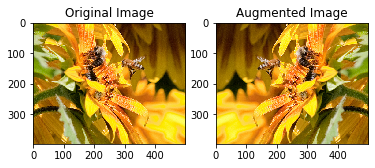

In [40]:
new_image=tf.image.flip_left_right(image)
visualize(image,new_image)

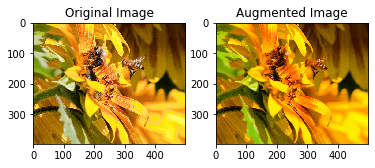

In [41]:
new_image=tf.image.adjust_saturation(image,4)
visualize(image,new_image)

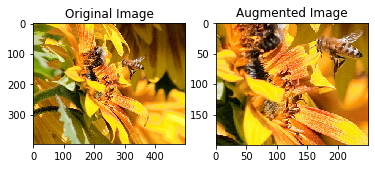

In [42]:
new_image=tf.image.central_crop(image,central_fraction=0.5)
visualize(image,new_image)

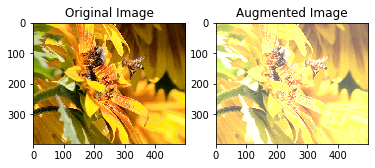

In [43]:
new_image=tf.image.adjust_brightness(image,0.4)
visualize(image,new_image)

Now let’s load an MobileNetV2 model, pretrained on ImageNet. We exclude the top of the network by setting include_top=False: this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based
on the output of the base_model, followed by a dense output layer with one unit per class(in total there are 5 classes), using the softmax activation function. Finally, we create the TF Keras Model.

In [44]:
base_model = keras.applications.MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [45]:
base_model.trainable=False

In [46]:
model=tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

It’s usually a good idea to freeze the weights of the pretrained
layers, at least at the beginning of training.

for layer in base_model.layers:
    layer.trainable = False

In [47]:
optimizer = keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================].9619 - accuracy: 0.34 - 9s 4s/step - loss: 3.0188 - accuracy: 0.29 - 10s 3s/step - loss: 3.4794 - accuracy: 0.260 - 11s 3s/step - loss: 5.1016 - accuracy: 0.296 - 12s 2s/step - loss: 7.8728 - accuracy: 0.306 - 13s 2s/step - loss: 9.7542 - accuracy: 0.349 - 14s 2s/step - loss: 12.6331 - accuracy: 0.33 - 15s 2s/step - loss: 14.2479 - accuracy: 0.32 - 16s 2s/step - loss: 14.0175 - accuracy: 0.33 - 18s 2s/step - loss: 12.9172 - accuracy: 0.36 - 19s 2s/step - loss: 12.9634 - accuracy: 0.37 - 20s 2s/step - loss: 12.5808 - accuracy: 0.38 - 21s 2s/step - loss: 12.3283 - accuracy: 0.39 - 22s 2s/step - loss: 12.0075 - accuracy: 0.40 - 23s 2s/step - loss: 11.7400 - accuracy: 0.41 - 24s 2s/step - loss: 11.5582 - accuracy: 0.41 - 25s 1s/step - loss: 11.1194 - accuracy: 0.43 - 27s 1s/step - loss: 10.8415 - accuracy: 0.44 - 28s 1s/step - loss: 10.8568 - accuracy: 0.45 - 29s 1s/step - loss: 10.9126 - accuracy: 0.45 - 30s 1s/step - loss: 11.1874 - accura

86/86 [==============================] - ETA: 11:28 - loss: 2.5148 - accuracy: 0.750 - ETA: 6:46 - loss: 4.1610 - accuracy: 0.703 - ETA: 5:08 - loss: 3.0110 - accuracy: 0.77 - ETA: 4:30 - loss: 3.3019 - accuracy: 0.76 - ETA: 4:03 - loss: 3.5694 - accuracy: 0.76 - ETA: 3:43 - loss: 3.4209 - accuracy: 0.77 - ETA: 3:30 - loss: 3.0234 - accuracy: 0.78 - ETA: 3:17 - loss: 2.8976 - accuracy: 0.80 - ETA: 3:10 - loss: 2.7676 - accuracy: 0.80 - ETA: 3:02 - loss: 2.7458 - accuracy: 0.80 - ETA: 2:56 - loss: 2.8858 - accuracy: 0.79 - ETA: 2:50 - loss: 2.8800 - accuracy: 0.79 - ETA: 2:43 - loss: 2.8375 - accuracy: 0.79 - ETA: 2:37 - loss: 2.7501 - accuracy: 0.80 - ETA: 2:34 - loss: 2.6449 - accuracy: 0.81 - ETA: 2:32 - loss: 2.7743 - accuracy: 0.80 - ETA: 2:28 - loss: 2.7109 - accuracy: 0.80 - ETA: 2:24 - loss: 2.7028 - accuracy: 0.80 - ETA: 2:20 - loss: 2.6242 - accuracy: 0.80 - ETA: 2:18 - loss: 2.6006 - accuracy: 0.80 - ETA: 2:15 - loss: 2.5300 - accuracy: 0.80 - ETA: 2:12 - loss: 2.4892 - accur

86/86 [==============================] - ETA: 4:17 - loss: 2.8232 - accuracy: 0.84 - ETA: 2:56 - loss: 2.0900 - accuracy: 0.84 - ETA: 2:24 - loss: 2.2555 - accuracy: 0.81 - ETA: 2:08 - loss: 2.0450 - accuracy: 0.82 - ETA: 1:57 - loss: 1.6980 - accuracy: 0.85 - ETA: 1:49 - loss: 1.8515 - accuracy: 0.83 - ETA: 1:45 - loss: 1.7096 - accuracy: 0.84 - ETA: 1:41 - loss: 1.5329 - accuracy: 0.85 - ETA: 1:38 - loss: 1.4654 - accuracy: 0.86 - ETA: 1:36 - loss: 1.3577 - accuracy: 0.86 - ETA: 1:33 - loss: 1.4120 - accuracy: 0.86 - ETA: 1:31 - loss: 1.3116 - accuracy: 0.86 - ETA: 1:28 - loss: 1.2770 - accuracy: 0.87 - ETA: 1:26 - loss: 1.3265 - accuracy: 0.86 - ETA: 1:24 - loss: 1.3207 - accuracy: 0.86 - ETA: 1:22 - loss: 1.3381 - accuracy: 0.85 - ETA: 1:20 - loss: 1.3164 - accuracy: 0.86 - ETA: 1:19 - loss: 1.4655 - accuracy: 0.85 - ETA: 1:18 - loss: 1.4532 - accuracy: 0.85 - ETA: 1:17 - loss: 1.4306 - accuracy: 0.85 - ETA: 1:16 - loss: 1.4564 - accuracy: 0.85 - ETA: 1:15 - loss: 1.6121 - accuracy

In [50]:
base_model.trainable=True

In [51]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9 ,decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

In [52]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] 2.2263 - accuracy: 0.75 - 61s 30s/step - loss: 5.5802 - accuracy: 0.68 - 66s 22s/step - loss: 9.0187 - accuracy: 0.56 - 72s 18s/step - loss: 12.4791 - accuracy: 0.515 - 77s 15s/step - loss: 14.8673 - accuracy: 0.468 - 81s 14s/step - loss: 14.1686 - accuracy: 0.427 - 85s 12s/step - loss: 13.4512 - accuracy: 0.433 - 90s 11s/step - loss: 12.3351 - accuracy: 0.418 - 94s 10s/step - loss: 11.2013 - accuracy: 0.413 - 98s 10s/step - loss: 10.2286 - accuracy: 0.409 - 102s 9s/step - loss: 9.5387 - accuracy: 0.383 - 105s 9s/step - loss: 9.0731 - accuracy: 0.38 - 109s 8s/step - loss: 8.6135 - accuracy: 0.37 - 113s 8s/step - loss: 8.1405 - accuracy: 0.36 - 117s 8s/step - loss: 7.8328 - accuracy: 0.35 - 121s 8s/step - loss: 7.5070 - accuracy: 0.34 - 125s 7s/step - loss: 7.2081 - accuracy: 0.33 - 129s 7s/step - loss: 6.9667 - accuracy: 0.31 - 133s 7s/step - loss: 6.7304 - accuracy: 0.31 - 137s 7s/step - loss: 6.5025 - accuracy: 0.31 - 141s 7s/step - lo

86/86 [==============================] - ETA: 7:43 - loss: 1.3481 - accuracy: 0.40 - ETA: 6:21 - loss: 1.5703 - accuracy: 0.34 - ETA: 5:58 - loss: 1.5844 - accuracy: 0.36 - ETA: 5:47 - loss: 1.5990 - accuracy: 0.35 - ETA: 5:35 - loss: 1.6185 - accuracy: 0.35 - ETA: 5:24 - loss: 1.5948 - accuracy: 0.33 - ETA: 5:17 - loss: 1.6137 - accuracy: 0.33 - ETA: 5:11 - loss: 1.5729 - accuracy: 0.36 - ETA: 5:04 - loss: 1.5449 - accuracy: 0.38 - ETA: 4:57 - loss: 1.6110 - accuracy: 0.38 - ETA: 4:52 - loss: 1.6670 - accuracy: 0.36 - ETA: 4:47 - loss: 1.7192 - accuracy: 0.36 - ETA: 4:42 - loss: 1.7221 - accuracy: 0.37 - ETA: 4:37 - loss: 1.6950 - accuracy: 0.38 - ETA: 4:32 - loss: 1.7011 - accuracy: 0.38 - ETA: 4:28 - loss: 1.6950 - accuracy: 0.37 - ETA: 4:25 - loss: 1.6946 - accuracy: 0.38 - ETA: 4:20 - loss: 1.6776 - accuracy: 0.38 - ETA: 4:15 - loss: 1.6818 - accuracy: 0.37 - ETA: 4:11 - loss: 1.7201 - accuracy: 0.37 - ETA: 4:07 - loss: 1.7327 - accuracy: 0.37 - ETA: 4:03 - loss: 1.7484 - accuracy

86/86 [==============================] - ETA: 9:11 - loss: 1.4076 - accuracy: 0.43 - ETA: 7:20 - loss: 1.3008 - accuracy: 0.46 - ETA: 6:50 - loss: 1.3492 - accuracy: 0.45 - ETA: 6:33 - loss: 1.2996 - accuracy: 0.46 - ETA: 6:15 - loss: 1.2787 - accuracy: 0.46 - ETA: 5:58 - loss: 1.2563 - accuracy: 0.46 - ETA: 5:45 - loss: 1.2602 - accuracy: 0.46 - ETA: 5:38 - loss: 1.2818 - accuracy: 0.45 - ETA: 5:30 - loss: 1.2921 - accuracy: 0.43 - ETA: 5:21 - loss: 1.3185 - accuracy: 0.43 - ETA: 5:14 - loss: 1.3140 - accuracy: 0.42 - ETA: 5:08 - loss: 1.3319 - accuracy: 0.42 - ETA: 5:02 - loss: 1.3525 - accuracy: 0.41 - ETA: 4:56 - loss: 1.3587 - accuracy: 0.40 - ETA: 4:50 - loss: 1.3753 - accuracy: 0.40 - ETA: 4:45 - loss: 1.3853 - accuracy: 0.40 - ETA: 4:41 - loss: 1.3806 - accuracy: 0.39 - ETA: 4:38 - loss: 1.3915 - accuracy: 0.39 - ETA: 4:32 - loss: 1.3963 - accuracy: 0.39 - ETA: 4:27 - loss: 1.3940 - accuracy: 0.39 - ETA: 4:23 - loss: 1.3978 - accuracy: 0.39 - ETA: 4:18 - loss: 1.3882 - accuracy